# Gaussian Processes xG Model

### Notebook Outline:

1. Use the features generated from data_processing.py and feature_engineering.py files
2. Train a Gaussian Processes Classifier and Sparse Gaussian Processes Classifier to find the probability of scoring given the features.
3. Train a series of ML models to find the probability of scoring given the features for comparative analysis.
4. Use the mean and variance of the output from the GP model to value players shooting ability.

The outline demonstrated below, along with player shooting valuation can be achieved by running main.py.

### Import libraries

In [21]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import random

import tensorflow_probability as tfp
import tensorflow as tf
import gpflow as gpflow

from mplsoccer import Pitch
import matplotlib.pyplot as plt
from bqplot import *

Allow extensions

In [13]:
!jupyter nbextension enable --py --sys-prefix bqplot
!jupyter nbextension enable --py --sys-prefix qgrid
!jupyter nbextension enable --py --sys-prefix widgetsnbextension

Enabling notebook extension bqplot/extension...
      - Validating: OK
Enabling notebook extension qgrid/extension...
      - Validating: OK
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


### Load Features

In [ ]:
from src.features.feature_engineering import FeatureEngineer

# Get path to data folder
sys.path.append('..')
data_folder = Path('../data')

# Load features
feature_df = pd.read_csv(data_folder / 'features/model_features_unscaled.csv')
features_names = [
            "x0_event", "y0_event", "angle", "distance_m", 
            "gk_distance_m", "gk_distance_y_m", 
            "triangle_opp", "triangle_tm", "close_players", 
            "head", "foot",
            'vx', 'vy', 'acc'
        ]

# Split and scale data
feature_engineer = FeatureEngineer()
X_train, X_test, X_val, \
    y_train, y_test, y_val, scaler = \
        feature_engineer.split_and_scale_data(
            feature_df, 
            features_names, 
            train_test_only=False
        )

path_tracking = data_folder / 'raw/tracking'
path_events = data_folder / 'raw/events'

# load event names
df_event_names = pd.read_csv(data_folder / 'processed/event_names.csv')
dict_event_names = df_event_names.set_index('event_type_id').to_dict()['event_description']

FeatureEngineer initialized with pitch (LxW): 100.0m x 100.0m, Goal width: 7.32m
Splitting and scaling data...
Data split (Train/Val/Cal): Train (1764), Validation (378), Calibration (378)


# GP Classifier Model

In [16]:
from gpflow.utilities import print_summary
gpflow.config.set_default_summary_fmt("notebook")

#GPFlow requires float specification
X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)
y_train = y_train.to_numpy().astype(np.float64).reshape(-1, 1)
y_test = y_test.to_numpy().astype(np.float64).reshape(-1, 1)
input_dim = X_train.shape[1]

### Standard Model

Functionality for Gaussian Process Classifer and Sparse Gaussian Process Classifier taken from GPFlow package (Matthews et al, 2017), but model and hyperparamter settings and testing tuned by myself.

In [17]:
# Set Random Seed for reproducibility
np.random.seed(42)
# Get the number of input features (input dimensions)
input_dim = X_train.shape[1]

# Define the kernel
lengthscales = tf.ones(input_dim, dtype=tf.float64)
kernel = gpflow.kernels.Matern52(lengthscales=lengthscales)

# Define priors for the kernel hyperparameters
dtype = gpflow.default_float()
concentration = tf.constant(2.0, dtype=dtype)
rate = tf.constant(0.5, dtype=dtype)
# Setting a Gamma prior on the variance parameter of the kernel
kernel.variance.prior = tfp.distributions.Gamma(concentration=concentration, rate=rate)
# Similarly, for lengthscales
kernel.lengthscales[0].prior = tfp.distributions.Gamma(concentration=concentration, rate=rate)

# Create the Bernoulli likelihood. This function has the logistic function built in for probabilistic predictions
likelihood = gpflow.likelihoods.Bernoulli()

#Create the GPC with variational approximation model for binary classification
GPC_model = gpflow.models.VGP(data=(X_train, y_train), likelihood=likelihood, kernel=kernel)

#Print the model
print_summary(GPC_model)

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,Gamma,True,(),float64,1.0
VGP.kernel.lengthscales,Parameter,Softplus,,True,"(14,)",float64,"[1., 1., 1...."
VGP.num_data,Parameter,Identity,,False,(),int32,1764
VGP.q_mu,Parameter,Identity,,True,"(1764, 1)",float64,[[0....
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 1764, 1764)",float64,"[[[1., 0., 0...."


Optimise the model using Varational Inference and L-BFGS-B

In [18]:
# Create the callback function with the specific loss function (GPC_model.training_loss)
def callback(loss_fn):
    def print_loss(iteration, variables, values):
        loss_value = loss_fn()
        print(f"Iteration {iteration}: Log Loss {loss_value:.4f}")
    return print_loss

print_loss_callback = callback(GPC_model.training_loss)

# Optimize the model - no difference between 1000 and 3000 iterations
opt = gpflow.optimizers.Scipy()
opt.minimize(
    GPC_model.training_loss,
    variables=GPC_model.trainable_variables,
    options=dict(maxiter=250),
    method="L-BFGS-B",
    step_callback=print_loss_callback
    )

Iteration 0: Log Loss 1473.1807
Iteration 1: Log Loss 1240.6337
Iteration 2: Log Loss 1199.4275
Iteration 3: Log Loss 1111.7158
Iteration 4: Log Loss 980.4898
Iteration 5: Log Loss 825.1492
Iteration 6: Log Loss 739.5241
Iteration 7: Log Loss 710.3945
Iteration 8: Log Loss 660.3018
Iteration 9: Log Loss 616.3621
Iteration 10: Log Loss 575.8274
Iteration 11: Log Loss 519.1304
Iteration 12: Log Loss 503.9624
Iteration 13: Log Loss 485.2077
Iteration 14: Log Loss 441.3794
Iteration 15: Log Loss 431.0974
Iteration 16: Log Loss 423.8759
Iteration 17: Log Loss 418.8156
Iteration 18: Log Loss 409.1756
Iteration 19: Log Loss 403.7738
Iteration 20: Log Loss 401.1238
Iteration 21: Log Loss 398.4665
Iteration 22: Log Loss 397.2516
Iteration 23: Log Loss 394.4793
Iteration 24: Log Loss 392.6766
Iteration 25: Log Loss 391.2985
Iteration 26: Log Loss 388.9497
Iteration 27: Log Loss 388.1184
Iteration 28: Log Loss 386.1524
Iteration 29: Log Loss 385.5193
Iteration 30: Log Loss 384.6630
Iteration 31: 

  message: STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
  success: False
   status: 1
      fun: 368.79444290624883
        x: [ 2.811e-01  9.286e-02 ...  7.676e+00  7.332e+00]
      nit: 250
      jac: [-1.058e-01 -5.726e-01 ... -2.332e-01 -5.085e-02]
     nfev: 270
     njev: 270
 hess_inv: <1558509x1558509 LbfgsInvHessProduct with dtype=float64>

Final model parameters

In [19]:
print_summary(GPC_model)

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,Gamma,True,(),float64,7.33223
VGP.kernel.lengthscales,Parameter,Softplus,,True,"(14,)",float64,"[3.25507, 14.32067, 16.34555..."
VGP.num_data,Parameter,Identity,,False,(),int32,1764
VGP.q_mu,Parameter,Identity,,True,"(1764, 1)",float64,[[2.81070e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 1764, 1764)",float64,"[[[1.1979e-01, 0.0000e+00, 0.0000e+00..."


### Performance

Accuracy of model: 92.1%
Log loss: 0.199
F1 Score: 0.605
ROC AUC: 0.932
Brier score: 0.0592
No of Goal predicted: 29 in 378 shots 7.672 %
Actual goals in test dataset:47
Actual goals in train dataset:220


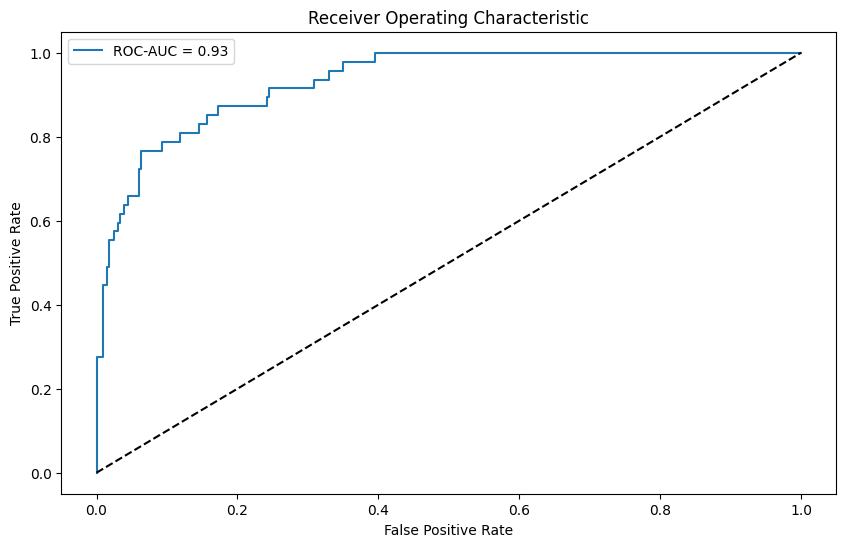

In [22]:
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, brier_score_loss, f1_score

mean, var = GPC_model.predict_y(X_test) # Get the predicted mean and variance for each test point
sample_mean, sample_var = GPC_model.predict_f(X_test) #This is used for collecting samples, i.e. real numbers as is the case before the invlink is performed.
pred_vals = (mean.numpy() > 0.5).astype(int) # Convert probabilities to binary predictions (0 or 1)

print(f'Accuracy of model: {accuracy_score(y_test, pred_vals)*100:.1f}%')
print("Log loss: %.3f" % log_loss(y_test, mean))
print("F1 Score: %.3f" % f1_score(y_test, pred_vals))
print("ROC AUC: %.3f" % roc_auc_score(y_test, mean))
print("Brier score: %.4f" % brier_score_loss(y_test, mean))

#Goal and shot count in training and test dataset
count_ones = np.count_nonzero(pred_vals == 1)
print("No of Goal predicted: {}".format(count_ones), "in {} shots".format(len(X_test)),"%.3f" % (count_ones/len(X_test)*100), '%')

actual_goals_test = np.count_nonzero(y_test == 1)
print("Actual goals in test dataset:{}".format(actual_goals_test))

actual_goals_train = np.count_nonzero(y_train == 1)
print("Actual goals in train dataset:{}".format(actual_goals_train))

#ROC CURVE
from sklearn.metrics import roc_curve, roc_auc_score, brier_score_loss
fpr, tpr, _ = roc_curve(y_test, mean)
auc = roc_auc_score(y_test, mean)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label="ROC-AUC = " + str(auc)[:4])
plt.plot([0, 1], [0, 1], color='black', ls='--')
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.show()


xG Mean and Var Distribution

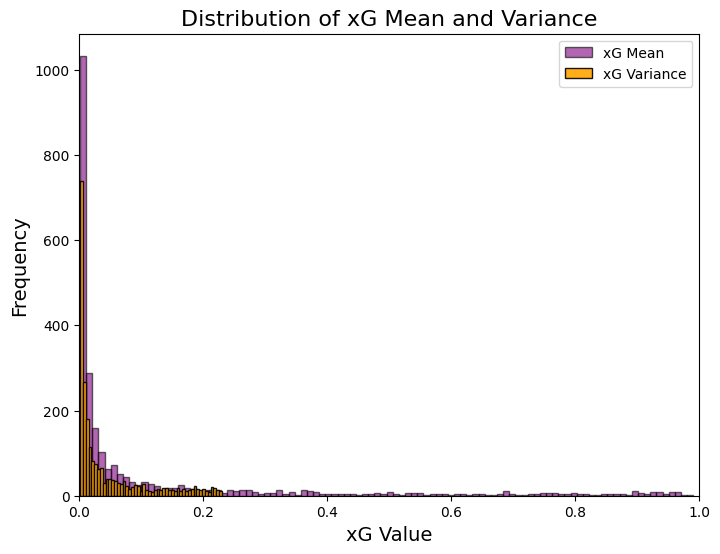

In [ ]:
#Add xG Mean and xG Var to the shots dataframe.
X_all = np.concatenate((X_train, X_test, X_val), axis=0) 
xG_mean, xG_var = GPC_model.predict_y(X_all)
xG_mean = np.array(xG_mean)
xG_var = np.array(xG_var)
feature_df['xG_Mean'] = xG_mean
feature_df['xG_Var'] = xG_var

# Plotting the distribution
plt.figure(figsize=(8, 6))

# Plotting xG_mean
plt.hist(xG_mean, bins=100, color='purple', edgecolor='black', alpha=0.6, label='xG Mean')

# Plotting xG_var
plt.hist(xG_var, bins=50, color='orange', edgecolor='black', alpha=0.9, label='xG Variance')

plt.xlabel('xG Value', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of xG Mean and Variance', fontsize=16)
plt.xlim(0, 1)
plt.legend()
plt.grid(False)
plt.show()

xG Mean Pitch Map

<Figure size 1000x1600 with 0 Axes>

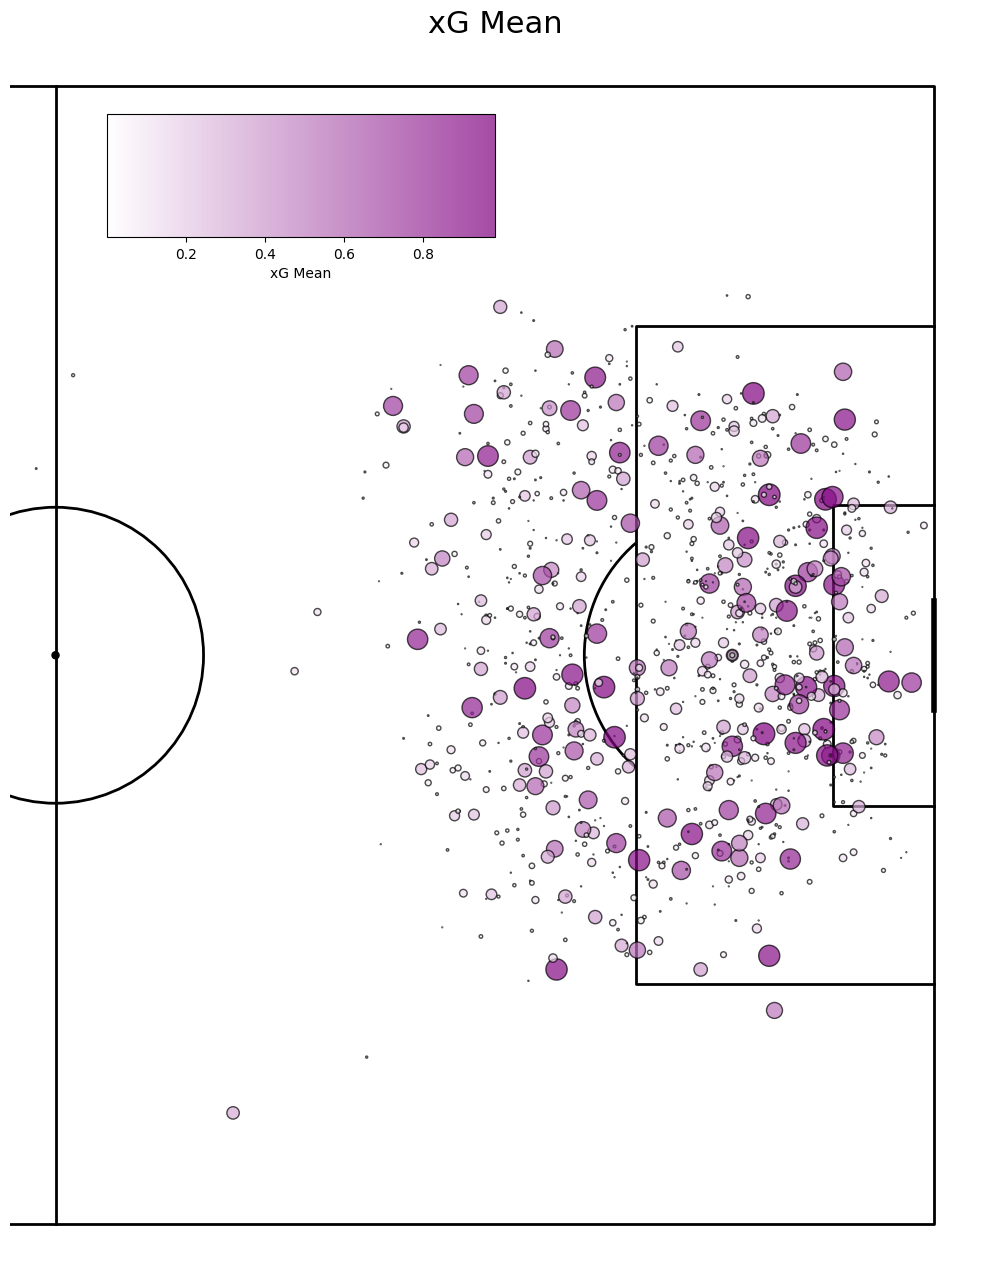

In [24]:
from matplotlib.colors import LinearSegmentedColormap

x_values = feature_df["x0_event"].values
y_values = feature_df["y0_event"].values
xg_values = feature_df["xG_Mean"].values

# Define the resolution of the heatmap
resolution = 100
colors = [(1, 1, 1), (0.5, 0, 0.5)]  # White to dark purple
cmap_custom = LinearSegmentedColormap.from_list('custom', colors)

buffer = 1000
x_values = feature_df["x0_event"][0:buffer]
y_values = feature_df["y0_event"][0:buffer]
xg_values = feature_df["xG_Mean"][0:buffer]

# Define the size scaling factor for xG values
size_scaling_factor = 250

# Create scatter plot
plt.figure(figsize=(10,16))

# Draw half pitch using mplsoccer
pitch = Pitch(pitch_type='opta', pitch_color='white', line_color='black', half=True)
fig, ax = pitch.draw(figsize=(10,16))

# Add scatter plot
scatter = ax.scatter(x_values, y_values, s=xg_values * size_scaling_factor, 
                    c=xg_values, cmap=cmap_custom, alpha=0.7, edgecolors='black')

# Add small colorbar inside pitch
cax = ax.inset_axes([0.1, 0.84, 0.4, 0.1]) # [x, y, width, height] in axes coordinates
plt.colorbar(scatter, cax=cax, label='xG Mean', orientation='horizontal')

plt.title('xG Mean', fontsize=22)
plt.grid(False)
plt.show()

xG Variance

<Figure size 1000x1600 with 0 Axes>

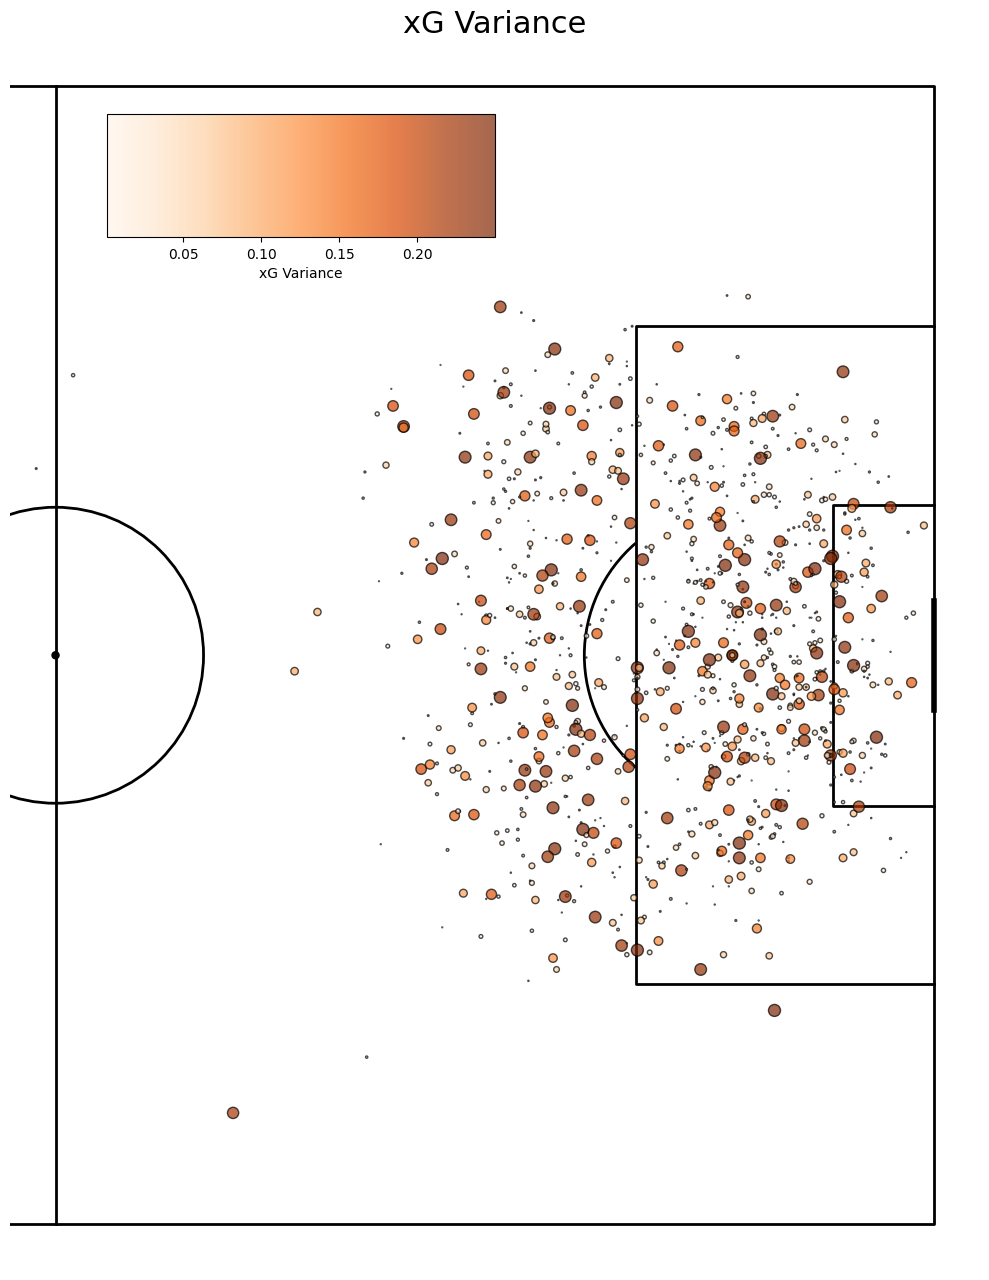

In [25]:
x_values = feature_df["x0_event"][0:buffer]
y_values = feature_df["y0_event"][0:buffer]
xg_values = feature_df["xG_Var"][0:buffer]

# Define the size scaling factor for xG values
size_scaling_factor = 300

# Create scatter plot
plt.figure(figsize=(10,16))

# Draw half pitch using mplsoccer
pitch = Pitch(pitch_type='opta', pitch_color='white', line_color='black', half=True)
fig, ax = pitch.draw(figsize=(10,16))

# Add scatter plot
scatter = ax.scatter(x_values, y_values, s=xg_values * size_scaling_factor, 
                    c=xg_values, cmap='Oranges', alpha=0.7, edgecolors='black')

# Add small colorbar inside pitch
cax = ax.inset_axes([0.1, 0.84, 0.4, 0.1]) # [x, y, width, height] in axes coordinates
plt.colorbar(scatter, cax=cax, label='xG Variance', orientation='horizontal')

plt.title('xG Variance', fontsize=22)
plt.grid(False)
plt.show()

# Sparse GPC

### Model 

In [26]:
input_dim = X_train.shape[1]

# Define the kernel 
kernel = gpflow.kernels.RBF(lengthscales=np.ones(input_dim))

# Define the likelihood for binary classification
likelihood = gpflow.likelihoods.Bernoulli()

# Number of inducing points
num_inducing_points = 1000  

# Randomly initialize the inducing point locations by selecting them from the input data X
np.random.seed(42)
inducing_indices = np.random.choice(len(X_train), num_inducing_points, replace=False)
inducing_X = X_train[inducing_indices]

# Create the inducing variable object
inducing_variable = gpflow.inducing_variables.InducingPoints(inducing_X)

# Create the SVGP model for binary classification with sparse GP using the inducing variable
SVGP_model = gpflow.models.SVGP(likelihood=likelihood, kernel=kernel, inducing_variable=inducing_variable)

# Print the model summary
print_summary(SVGP_model)

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.lengthscales,Parameter,Softplus,,True,"(14,)",float64,"[1., 1., 1...."
SVGP.inducing_variable.Z,Parameter,Identity,,True,"(1000, 14)",float64,"[[1.07679, -0.97273, -0.5216..."
SVGP.q_mu,Parameter,Identity,,True,"(1000, 1)",float64,[[0....
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 1000, 1000)",float64,"[[[1., 0., 0...."


Optimisation

In [27]:
X_train_tensor, y_train_tensor = tf.convert_to_tensor(X_train), tf.convert_to_tensor(y_train)
data = (X_train_tensor, y_train_tensor)

@tf.function(autograph=True)
def loss_cb():
    return -SVGP_model.maximum_log_likelihood_objective(data)

opt = gpflow.optimizers.Scipy()
opt = opt.minimize(loss_cb, SVGP_model.trainable_variables,
                        options=dict(maxiter=500),
                        method="L-BFGS-B",
                        # step_callback=tf.function(lambda x: print(f"Log Likelihood: {loss_cb().numpy():.2f}")),
                        compile=True
                        )

print_summary(SVGP_model)

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,14.11039
SVGP.kernel.lengthscales,Parameter,Softplus,,True,"(14,)",float64,"[3.52955, 30.43944, 13.90223..."
SVGP.inducing_variable.Z,Parameter,Identity,,True,"(1000, 14)",float64,"[[0.95415, -1.05072, -1.32409..."
SVGP.q_mu,Parameter,Identity,,True,"(1000, 1)",float64,[[-2.29940e-01...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 1000, 1000)",float64,"[[[1.15670e-01, 0.00000e+00, 0.00000e+00..."


Model Performance

Accuracy of model: 91.5%
Log loss: 0.203
F1 Score: 0.556
ROC AUC: 0.929
Brier score: 0.0609
No of Goal predicted: 25 in 378 shots 6.614 %
Actual goals in test dataset:47
Actual goals in train dataset:220


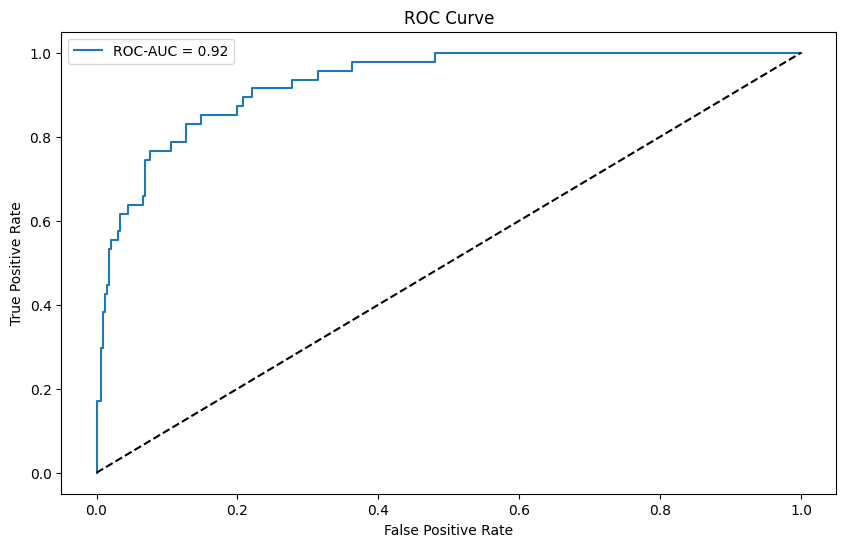

In [28]:
mean, var = SVGP_model.predict_y(X_test) #Use this for plotting
pred_vals = (mean.numpy() > 0.50).astype(int) # Convert probabilities to binary predictions (0 or 1)

print(f'Accuracy of model: {accuracy_score(y_test, pred_vals)*100:.1f}%')
print("Log loss: %.3f" % log_loss(y_test, mean))
print("F1 Score: %.3f" % f1_score(y_test, pred_vals))
print("ROC AUC: %.3f" % roc_auc_score(y_test, mean))
print("Brier score: %.4f" % brier_score_loss(y_test, mean))

#Goal and shot count in training and test dataset
count_ones = np.count_nonzero(pred_vals == 1)
print("No of Goal predicted: {}".format(count_ones), "in {} shots".format(len(X_test)),"%.3f" % (count_ones/len(X_test)*100), '%')

actual_goals_test = np.count_nonzero(y_test == 1)
print("Actual goals in test dataset:{}".format(actual_goals_test))

actual_goals_train = np.count_nonzero(y_train == 1)
print("Actual goals in train dataset:{}".format(actual_goals_train))

fpr, tpr, _ = roc_curve(y_test, mean)
auc = roc_auc_score(y_test, mean)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label="ROC-AUC = " + str(auc)[:4])
plt.plot([0, 1], [0, 1], color='black', ls='--')
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()


### ARD Analysis 

Reveal importance of the variables in predicting the outcome of a shot

In [29]:
lengthscales = GPC_model.kernel.lengthscales.numpy()
sorted_vars = sorted(zip(features_names, lengthscales), key=lambda x: x[1], reverse=True)
print("Variables and their Lengthscales (in order of importance):")
for name, lengthscale in reversed(sorted_vars):
    print(f"{name}: {lengthscale:.2f}")

Variables and their Lengthscales (in order of importance):
gk_distance_m: 2.77
vx: 3.02
x0_event: 3.26
gk_distance_y_m: 5.60
close_players: 5.97
acc: 7.68
distance_m: 9.40
triangle_opp: 10.92
y0_event: 14.32
vy: 15.27
angle: 16.35
head: 18.27
foot: 18.27
triangle_tm: 19.45


# Logistic Regression

Use the all features and a logistic regression as a benchmark for analysing players.

In [31]:
#Fit the model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, f1_score, roc_auc_score, brier_score_loss

#Fit a logisitic model
logistic_reg = LogisticRegression(random_state=42)
logistic_reg.fit(X_train, y_train.ravel()) # Ravel y_train to 1D array

#Previously used X_cal and y_cal, now using X-test and y_test 
y_pred = logistic_reg.predict(X_test)
pred_vals = logistic_reg.predict(X_test)

print(f'Accuracy of model: {accuracy_score(y_test, pred_vals)*100:.1f}%')
print("Log loss: %.3f" % log_loss(y_test, y_pred))
print("F1 Score: %.3f" % f1_score(y_test, pred_vals))
print("ROC AUC: %.3f" % roc_auc_score(y_test, y_pred))
print("Brier score: %.4f" % brier_score_loss(y_test, y_pred))

#Goal and shot count in training and test dataset
count_ones = np.count_nonzero(pred_vals == 1)
print("No of Goal predicted: {}".format(count_ones), "in {} shots".format(len(X_test)),"%.3f" % (count_ones/len(X_test)*100), '%')

actual_goals_test = np.count_nonzero(y_test == 1)
print("Actual goals in test dataset:{}".format(actual_goals_test))

actual_goals_train = np.count_nonzero(y_train == 1)
print("Actual goals in train dataset:{}".format(actual_goals_train))

Accuracy of model: 92.3%
Log loss: 2.765
F1 Score: 0.603
ROC AUC: 0.728
Brier score: 0.0767
No of Goal predicted: 26 in 378 shots 6.878 %
Actual goals in test dataset:47
Actual goals in train dataset:220


# Neural Network - Multi-layered Perceptron 


After standardising the data and splitting for training, testing and calibration, we use a multi-layer perceptron with 3 dense layered with ReLU activation and 1 output layer with sigmoid activation given the binary nature of the task in hand. We use L2 kernel regulariser to avoid overfitting in the first layer.
The model minimizes the binary cross entropy using Adam optimiser with a decaying schedule. Early stopping with min delta 1e-5 and patience of 40. 

Epoch 1/1000
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5115 - loss: 1.6128 - val_accuracy: 0.8307 - val_loss: 1.2494
Epoch 2/1000
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7447 - loss: 1.2201 - val_accuracy: 0.8995 - val_loss: 1.0190
Epoch 3/1000
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8516 - loss: 0.9809 - val_accuracy: 0.9021 - val_loss: 0.8495
Epoch 4/1000
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8812 - loss: 0.8089 - val_accuracy: 0.9074 - val_loss: 0.7216
Epoch 5/1000
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8877 - loss: 0.6974 - val_accuracy: 0.9074 - val_loss: 0.6248
Epoch 6/1000
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8901 - loss: 0.6047 - val_accuracy: 0.9074 - val_loss: 0.5497
Epoch 7/1000
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8928 - loss: 0.5469 - val_accuracy: 0.9048 - val_loss: 0.4954
Epoch 8/1000
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9068 - loss: 0.4859 - val_accuracy: 0

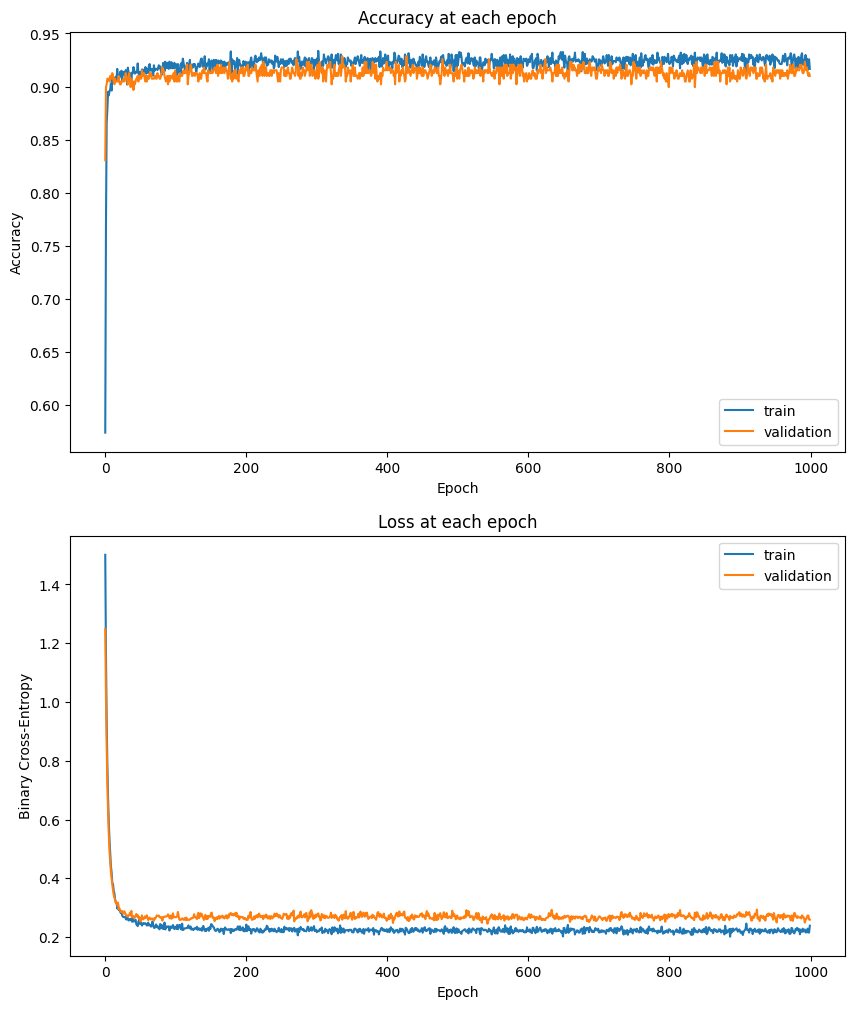

In [34]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

#  Set the random seeds
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

def MLP():
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(64, kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.5))
    
    model.add(Dense(32, kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    
    model.add(Dense(16, kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Dense(1, activation='sigmoid'))
    
    opt = Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss="binary_crossentropy", metrics=['accuracy'])
    return model

# Callbacks
early_stopping = EarlyStopping(min_delta=1e-5, patience=20, mode="min", monitor="val_loss", restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
callback = EarlyStopping(min_delta=1e-5, patience = 40, mode = "min", monitor = "val_loss", restore_best_weights=True)

# Fit the model
MLP = MLP()
history = MLP.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000, verbose=1, batch_size=32)

#Plot the training curves 
fig, axs = plt.subplots(2, figsize=(10,12))

#Training curve - accuracy
axs[0].plot(history.history['accuracy'], label='train')   
axs[0].plot(history.history['val_accuracy'], label='validation')
axs[0].set_title("Accuracy at each epoch")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

#Training curve - loss
axs[1].plot(history.history['loss'], label='train')   
axs[1].plot(history.history['val_loss'], label='validation')
axs[1].legend()
axs[1].set_title("Loss at each epoch")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Binary Cross-Entropy")
plt.show()

# Boosted Decision Tree 

In [35]:
# CatBoost
from catboost import CatBoostClassifier
cat_model = CatBoostClassifier(verbose=False)
cat_model.fit(X_train, y_train)

y_pred = [p[1] for p in cat_model.predict_proba(X_test)]

pred_vals = cat_model.predict(X_test)

print(f'Accuracy of model: {accuracy_score(y_test, pred_vals)*100:.1f}%')
print("Log loss: %.3f" % log_loss(y_test, y_pred))
print("F1 Score: %.3f" % f1_score(y_test, pred_vals))
print("ROC AUC: %.3f" % roc_auc_score(y_test, y_pred))
print("Brier score: %.4f" % brier_score_loss(y_test, y_pred))

#Goal and shot count in training and test dataset
count_ones = np.count_nonzero(pred_vals == 1)
print("No of Goal predicted: {}".format(count_ones), "in {} shots".format(len(X_test)),"%.3f" % (count_ones/len(X_test)*100), '%')
actual_goals_test = np.count_nonzero(y_test == 1)
print("Actual goals in test dataset:{}".format(actual_goals_test))
actual_goals_train = np.count_nonzero(y_train == 1)
print("Actual goals in train dataset:{}".format(actual_goals_train))

Accuracy of model: 92.3%
Log loss: 0.201
F1 Score: 0.613
ROC AUC: 0.929
Brier score: 0.0588
No of Goal predicted: 28 in 378 shots 7.407 %
Actual goals in test dataset:47
Actual goals in train dataset:220


# Performance Comparison

### ROC CURVES


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


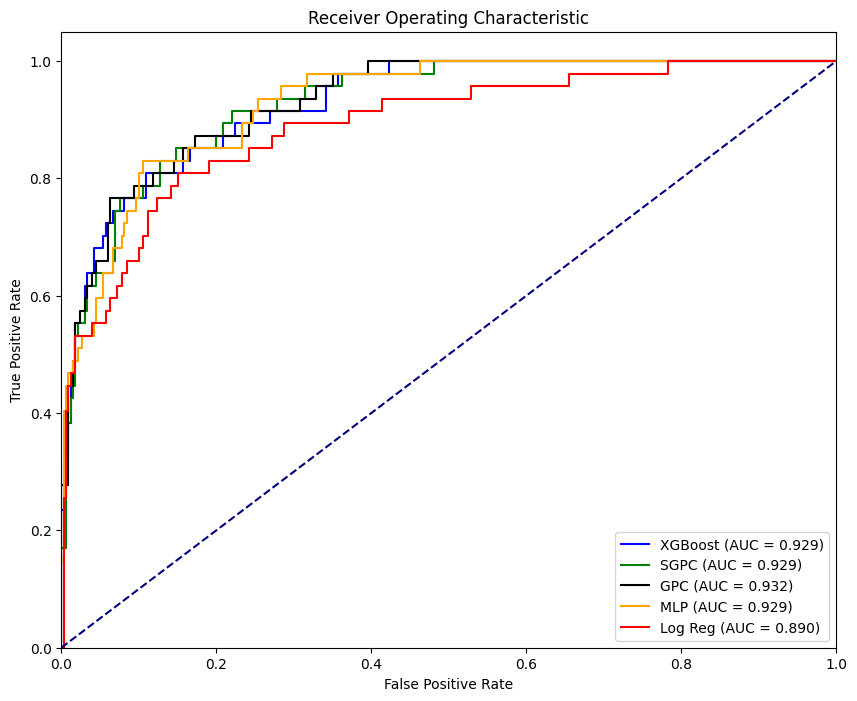

In [36]:
# Calculate ROC curve for each model
from sklearn.metrics import roc_curve, auc

#XGBoost:
y_pred_XG = [p[1] for p in cat_model.predict_proba(X_test)]

#SGPC
y_pred_SP, var_SP = SVGP_model.predict_y(X_test)

#GPC
y_pred_GP, var_GP = GPC_model.predict_y(X_test)

#MLP 
y_pred_MLP = MLP.predict(X_test)

#Logistic Regression
y_pred_LR = logistic_reg.predict_proba(X_test)[:, 1]

fpr1, tpr1, _ = roc_curve(y_test, y_pred_XG)
fpr2, tpr2, _ = roc_curve(y_test, y_pred_SP)
fpr3, tpr3, _ = roc_curve(y_test, y_pred_GP)
fpr4, tpr4, _ = roc_curve(y_test, y_pred_MLP)
fpr5, tpr5, _ = roc_curve(y_test, y_pred_LR)

# Calculate the AUC for each model
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)
roc_auc5 = auc(fpr5, tpr5)

# Plotting
plt.figure(figsize=(10, 8))

plt.plot(fpr1, tpr1, color='blue', label=f'XGBoost (AUC = {roc_auc1:.3f})')
plt.plot(fpr2, tpr2, color='green', label=f'SGPC (AUC = {roc_auc2:.3f})')
plt.plot(fpr3, tpr3, color='black', label=f'GPC (AUC = {roc_auc3:.3f})')
plt.plot(fpr4, tpr4, color='orange', label=f'MLP (AUC = {roc_auc4:.3f})')
plt.plot(fpr5, tpr5, color='red', label=f'Log Reg (AUC = {roc_auc5:.3f})')

# Diagonal line
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.show()

# Plot Shots

In [38]:
from src.features.data_processing import DataProcessor
data_processor = DataProcessor('../data/raw', '../data/processed')

shots_tracking_df = pd.read_csv('../data/processed/shot_tracking_df.csv')
shots_event_df = pd.read_csv('../data/processed/shot_event_df.csv')
goalkeepers_df = pd.read_csv('../data/processed/goalkeepers.csv')

shots_tracking_df = data_processor._enrich_tracking_data(shots_tracking_df, shots_event_df, goalkeepers_df)

Enriching tracking data with shooter, goalkeeper, and team status...


In [44]:

from src.viz.animation import BasicPlot
selected_frames = ['88_1_2596.96', '31_1_2650.0','33_1_2157.48']
selected_shots = feature_df[feature_df['t_frame_id'].isin(selected_frames)]

for index, row in selected_shots.iterrows():
    game_id, current_phase, timeelapsed = map(float, row['t_frame_id'].split('_'))

    # Step 2: Create BasicPlot instance
    basic_plot_instance = BasicPlot(df_tracking=shots_tracking_df, game_id=game_id, pitch_img='../img/pitch_white.png')

    # Step 3: Set the data for a specific frame
    period = int(current_phase)
    time_elapsed = timeelapsed
    selected_frame = (period, time_elapsed)
    basic_plot_instance.set_data(selected_frame)

    # Step 4: Display the plot
    display(basic_plot_instance)
    print(f"Frame: {row['t_frame_id']}")
    print(f"Predicted xG mean: {row['xG_Mean']:.2f}")
    print(f"Predicted xG variance: {row['xG_Var']:.2f}")
    print(f"Goal: {row['goal']}")
    print(f"GK Distance: {row['gk_distance_m']:.2f}")
    print(f"Distance: {row['distance_m']:.2f}")
    print(f"Angle: {row['angle']:.2f}")
    print(f"Close Players: {row['close_players']}")
    print(f"Head: {row['head']}")

BasicPlot(children=(Figure(fig_margin={'top': 0, 'bottom': 0, 'left': 30, 'right': 30}, layout=Layout(height='…

Frame: 88_1_2596.96
Predicted xG mean: 0.08
Predicted xG variance: 0.07
Goal: 0
GK Distance: 12.69
Distance: 22.24
Angle: 11.69
Close Players: 2
Head: 0


BasicPlot(children=(Figure(fig_margin={'top': 0, 'bottom': 0, 'left': 30, 'right': 30}, layout=Layout(height='…

Frame: 31_1_2650.0
Predicted xG mean: 0.19
Predicted xG variance: 0.15
Goal: 0
GK Distance: 21.08
Distance: 23.02
Angle: 18.05
Close Players: 1
Head: 0


BasicPlot(children=(Figure(fig_margin={'top': 0, 'bottom': 0, 'left': 30, 'right': 30}, layout=Layout(height='…

Frame: 33_1_2157.48
Predicted xG mean: 0.16
Predicted xG variance: 0.14
Goal: 0
GK Distance: 6.65
Distance: 14.63
Angle: 8.10
Close Players: 1
Head: 0
